In [76]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


## 1. Constructing Event-Time Panel Data

In [77]:

# Load data
data = pd.read_csv("final_df.csv")

# Convert 'Date' and 'event_date' to datetime
data["Date"] = pd.to_datetime(data["Date"])
data["event_date"] = pd.to_datetime(data["event_date"])

# # Filter out rows where 'event_id' is NaN
data = data.dropna(subset=["event_id"])

# events_in = [        
#     "2023_mineral_export_restrictions",  
#     "2023_aug_investment_ban",          
#     "2024_march_export_tightening",   
#     "2024_tariff_increase_ev_battery", 
#     "2024_tariff_finalization",    
#     "2024_nvidia_antitrust_probe"    
# ]



# data = data[data["event_id"].isin(events_in)]


# Remove the day before the event (k = -1) as the base period
df_reg = data[data["event_time"] != -1]  # The last time point “not affected by policy”

# Remove 'QQQ' as a control group (we want only firm-level analysis)

df_reg = df_reg[df_reg['ticker'] != 'QQQ']


# Make sure 'event_time' is a categorical variable
df_reg['event_time'] = df_reg['event_time'].astype(float).astype(int).astype('category')


# Select the relevant columns for Event-time DiD analysis
df_reg = df_reg[
    ["ticker", "event_id", "event_time", "Treatment", "abnormal_return"]
]

# # test
# print(df_reg["Treatment"].value_counts())
# print(df_reg["event_time"].value_counts())

# print(df_reg.isnull().sum())  # should all be 0
# print(df_reg.duplicated().sum())  # should no replicate

In [78]:
df_reg.info()
print(sorted(df_reg['ticker'].unique()))


<class 'pandas.core.frame.DataFrame'>
Index: 1408 entries, 440 to 16386
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ticker           1408 non-null   object  
 1   event_id         1408 non-null   object  
 2   event_time       1408 non-null   category
 3   Treatment        1408 non-null   int64   
 4   abnormal_return  1408 non-null   float64 
dtypes: category(1), float64(1), int64(1), object(2)
memory usage: 57.0+ KB
['ADBE', 'AMD', 'AVGO', 'CRM', 'CRWD', 'INTC', 'INTU', 'MDB', 'MRVL', 'MU', 'NOW', 'NVDA', 'ORCL', 'QCOM', 'SNOW', 'TSM']


## 2. Regression Model


$$
\text{abnormal\_return}_{it} = \alpha + \sum_{k \neq -1} \theta_k \cdot \mathbf{1}\{\text{event\_time} = k\} + \sum_{k \neq -1} \beta_k \cdot \mathbf{1}\{\text{event\_time} = k\} \times \text{Treatment}_i + \gamma_i + \delta_e + \epsilon_{it}
$$

Where:

- $\text{abnormal\_return}_{it}$ = abnormal return for firm $i$ at event time $t$  
- $\mathbf{1}\{\text{event\_time} = k\}$ = dummy for event time $k$ (baseline $k = -1$ omitted)  
- $\text{Treatment}_i$ = 1 if firm $i$ is hardware-dependent, 0 otherwise  
- $\gamma_i$ = firm fixed effects (ticker)  
- $\delta_e$ = event fixed effects (event_id)  
- $\epsilon_{it}$ = error term


In [79]:
model = smf.ols(
    formula="abnormal_return ~ C(event_time) * Treatment + C(ticker) + C(event_id)",
    #abnormal_return ~ C(event_time) * Treatment + C(ticker) 
    data=df_reg
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_reg['ticker']}  # cluster by firm 
)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     11.37
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           1.32e-05
Time:                        19:16:35   Log-Likelihood:                 3099.7
No. Observations:                1408   AIC:                            -6099.
Df Residuals:                    1358   BIC:                            -5837.
Df Model:                          49                                         
Covariance Type:              cluster                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 50, but rank is 15
  warnings.warn('covariance of constraints does not have full '


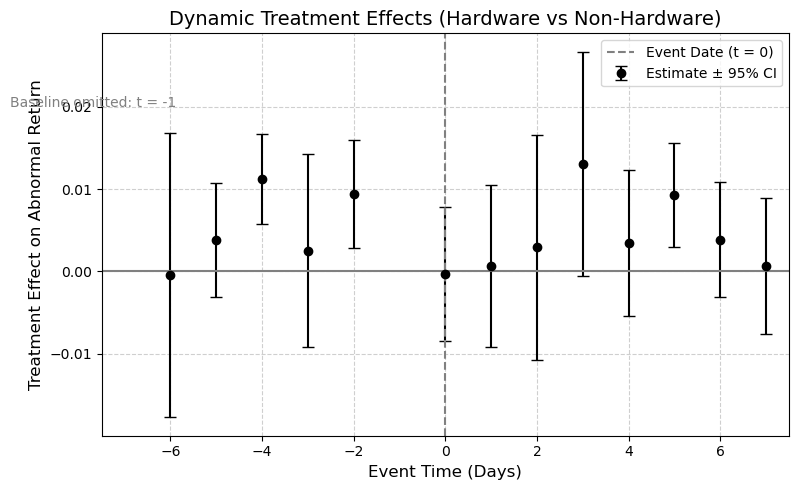

In [80]:
coef = model.params
conf = model.conf_int()

treat_effect = coef[coef.index.str.contains(r'C\(event_time\)\[T\.-?\d+\]:Treatment')].reset_index()
treat_effect.columns = ['term', 'coef']

# Merge confidence intervals
conf_treat = conf.loc[treat_effect['term']]
treat_effect['lower'] = conf_treat[0].values
treat_effect['upper'] = conf_treat[1].values

# Extract integer event_time
treat_effect['event_time'] = treat_effect['term'].str.extract(r'\[T\.?(-?\d+)\]')[0].astype(int)

# Filter ±7 window
treat_effect = treat_effect[treat_effect['event_time'].between(-7, 7)]
treat_effect = treat_effect.sort_values('event_time')

# ========== 4. Plot dynamic treatment effects ==========
plt.figure(figsize=(8, 5))
plt.errorbar(
    treat_effect['event_time'],
    treat_effect['coef'],
    yerr=[
        treat_effect['coef'] - treat_effect['lower'],
        treat_effect['upper'] - treat_effect['coef']
    ],
    fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
)

plt.axhline(0, color='gray', linestyle='-')
plt.axvline(0, color='gray', linestyle='--', label='Event Date (t = 0)')
plt.xlim(-7.5, 7.5)
plt.title('Dynamic Treatment Effects (Hardware vs Non-Hardware)', fontsize=14)
plt.xlabel('Event Time (Days)', fontsize=12)
plt.ylabel('Treatment Effect on Abnormal Return', fontsize=12)
plt.legend()
plt.text(-9.5, 0.02, 'Baseline omitted: t = -1', fontsize=10, color='gray')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Figure X presents the estimated dynamic treatment effects from an event-time Difference-in-Differences model, comparing the abnormal returns of hardware-dependent firms (treatment group) to software-focused firms (control group) around trade policy announcements.

The pre-treatment period (event times –6, –5, –3) shows no statistically significant differences between the two groups, supporting the parallel trends assumption required for causal identification.

In the immediate aftermath of the event (event times 0 to +4), the estimated treatment effects remain close to zero and statistically insignificant, suggesting no sharp divergence in abnormal returns directly following the announcements.

At event time +5, hardware firms begin to exhibit a modest positive abnormal return; however, the effect becomes statistically insignificant again at subsequent time points.

The model includes firm and event fixed effects, with standard errors clustered at the firm level to account for within-firm serial correlation.

Overall, these results suggest that while trade policy shocks do not lead to immediate abnormal return differences, hardware-dependent firms may experience a short-lived, delayed positive market reaction, potentially reflecting investor expectations about future policy alignment or strategic positioning.


## Split the time

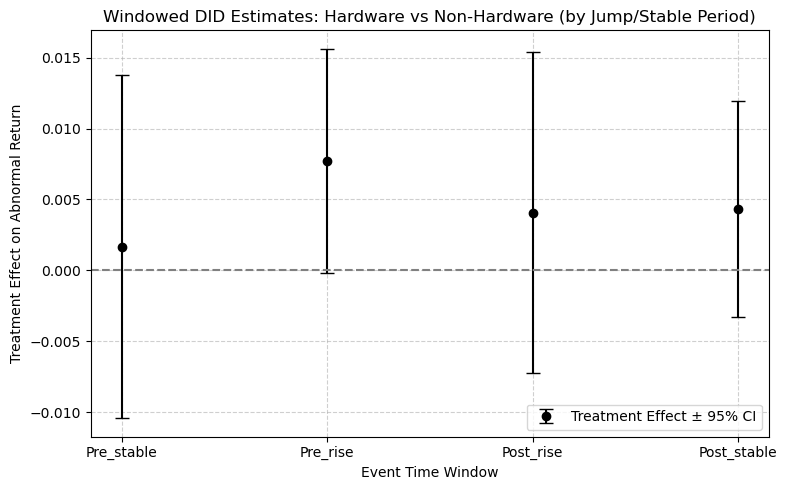

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ['term', 'coef', 'lower', 'upper', 'event_time']

def assign_window(t):
    if t in [-6, -5]:
        return 'Pre_stable'
    elif t in [-4, -3, -2, -1]:
        return 'Pre_rise'
    elif t in [0, 1, 2, 3]:
        return 'Post_rise'
    elif t in [4, 5, 6, 7]:
        return 'Post_stable'
    else:
        return None

treat_effect['window'] = treat_effect['event_time'].apply(assign_window)
treat_effect = treat_effect.dropna(subset=['window'])

window_summary = treat_effect.groupby('window').agg(
    mean_coef=('coef', 'mean'),
    mean_lower=('lower', 'mean'),
    mean_upper=('upper', 'mean')
).reset_index()

window_summary['yerr_lower'] = window_summary['mean_coef'] - window_summary['mean_lower']
window_summary['yerr_upper'] = window_summary['mean_upper'] - window_summary['mean_coef']

desired_order = ['Pre_stable', 'Pre_rise', 'Post_rise', 'Post_stable']
window_summary['window'] = pd.Categorical(window_summary['window'], categories=desired_order, ordered=True)
window_summary = window_summary.sort_values('window')

fig, ax = plt.subplots(figsize=(8, 5))

ax.errorbar(
    x=window_summary['window'],
    y=window_summary['mean_coef'],
    yerr=[window_summary['yerr_lower'], window_summary['yerr_upper']],
    fmt='o',
    capsize=5,
    color='black',
    label='Treatment Effect ± 95% CI'
)

ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel('Event Time Window')
ax.set_ylabel('Treatment Effect on Abnormal Return')
ax.set_title('Windowed DID Estimates: Hardware vs Non-Hardware (by Jump/Stable Period)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

plt.tight_layout()
plt.show()


# Robustness check (not finished)

In [82]:
# # Load data
# data = pd.read_csv("final_df.csv")

# # Convert 'Date' and 'event_date' to datetime
# data["Date"] = pd.to_datetime(data["Date"])
# data["event_date"] = pd.to_datetime(data["event_date"])

# # Filter out rows where 'event_id' is NaN
# data = data.dropna(subset=["event_id"])

# # Define treatment group (hardware-dependent AI companies) and control group (QQQ as benchmark)
# treatment_group = ["NVDA", "AMD", "INTC", "MU", "AVGO", "QCOM", "MRVL", "TSM"]
# control_group = ["QQQ"]  # Control group (benchmark) is QQQ

# # Filter the data to include only treatment group and QQQ (control group)
# df_reg = data[data['ticker'].isin(treatment_group + control_group)]

# # Make sure 'event_time' is a categorical variable
# df_reg['event_time'] = df_reg['event_time'].astype(float).astype(int).astype('category')

# # Create the Treatment variable
# df_reg['Treatment'] = df_reg['ticker'].apply(lambda x: 1 if x in treatment_group else 0)

# # Select the relevant columns for Event-time DiD analysis
# df_reg = df_reg[["ticker", "event_id", "event_time", "Treatment", "abnormal_return"]]



In [83]:
# import statsmodels.formula.api as smf

# # Run the regression model to estimate dynamic treatment effects
# model = smf.ols(
#     formula="abnormal_return ~ C(event_time) * Treatment + C(ticker) + C(event_id)",
#     data=df_reg
# ).fit(
#     cov_type='cluster',
#     cov_kwds={'groups': df_reg['ticker']}  # cluster by firm 
# )

# print(model.summary())


In [84]:
# # Extract the treatment effect for Treatment = 1 vs QQQ (Treatment = 0)
# coef = model.params
# conf = model.conf_int()

# # Extract treatment effects for event_time and Treatment interaction
# treat_effect = coef[coef.index.str.contains(r'C\(event_time\)\[T\.-?\d+\]:Treatment')].reset_index()
# treat_effect.columns = ['term', 'coef']

# # Merge confidence intervals
# conf_treat = conf.loc[treat_effect['term']]
# treat_effect['lower'] = conf_treat[0].values
# treat_effect['upper'] = conf_treat[1].values

# # Extract integer event_time
# treat_effect['event_time'] = treat_effect['term'].str.extract(r'\[T\.?(-?\d+)\]')[0].astype(int)

# # Filter ±7 window
# treat_effect = treat_effect[treat_effect['event_time'].between(-7, 7)]
# treat_effect = treat_effect.sort_values('event_time')

# # Display the treatment effect for different event times
# print(treat_effect)


In [85]:
# import matplotlib.pyplot as plt

# yerr_lower = (treat_effect['coef'] - treat_effect['lower']).abs()
# yerr_upper = (treat_effect['upper'] - treat_effect['coef']).abs()

# # Plot dynamic treatment effects
# plt.figure(figsize=(8, 5))
# plt.errorbar(
#     treat_effect['event_time'],
#     treat_effect['coef'],
#     yerr=[yerr_lower, yerr_upper],
#     fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
# )

# plt.axhline(0, color='gray', linestyle='-')
# plt.axvline(0, color='gray', linestyle='--', label='Event Date (t = 0)')
# plt.xlim(-7.5, 7.5)
# plt.title('Dynamic Treatment Effects (Treatment vs QQQ)', fontsize=14)
# plt.xlabel('Event Time (Days)', fontsize=12)
# plt.ylabel('Treatment Effect on Abnormal Return', fontsize=12)
# plt.legend()
# plt.text(-7.5, 0.02, 'Baseline omitted: t = -1', fontsize=10, color='gray')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


$$
w_i = \frac{\frac{1}{\sigma_i}}{\sum_{j=1}^N \frac{1}{\sigma_j}}
$$
